# PV data from the IPE battery container

This script should collect the pv generation data from the IPE PV plant. Selected measurements are: current, voltage, power, etc. 

In [2]:
#!pip install influxdb
#!pip install matplotlib

In [32]:
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Configuration parameters
host = '141.52.65.125'
port = 8086
dbname = 'iobroker'
user = 'admin'
password = 'Karlsruhe23!'
duration_hours = 12  # Duration from now to collect data, in hours

# Calculate necessary query granularity to not exceed 800 data points
max_data_points = 800
query_interval_minutes = max(1, (duration_hours * 60) // max_data_points)

# Initialize the client and connect to the database
client = InfluxDBClient(host, port, user, password, dbname)

# Adjust the query to dynamically use the calculated interval
query = f'SELECT mean("value") FROM "modbus.0.inputRegisters.30775_AC_Wirkleistung" ' \
        f'WHERE time > now() - {duration_hours}h GROUP BY time({query_interval_minutes}m) fill(null)'

# Execute the query
result = client.query(query)

# Prepare data for plotting
times = []
values = []
for point in result.get_points():
    times.append(datetime.strptime(point['time'], '%Y-%m-%dT%H:%M:%SZ'))  # Convert times to datetime objects
    values.append(point['mean'])

# Close the client
client.close()


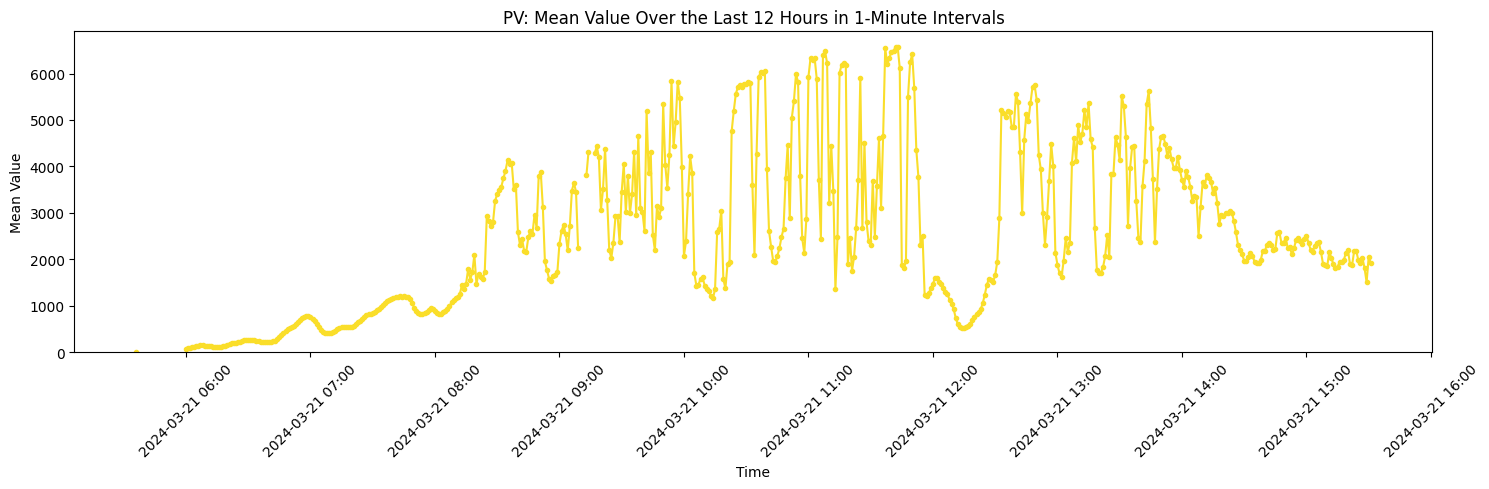

In [33]:
# Plotting
plt.figure(figsize=(15, 5))

# Use fill_between for filling under the line, with a strong yellow color
plt.plot(times, values, marker='o', linestyle='-', markersize=3, color='#fade2a')  # Strong yellow line

plt.title(f'PV: Mean Value Over the Last {duration_hours} Hours in {query_interval_minutes}-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Mean Value')

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Set up the date formatter for the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()